# Final Project - Stage 3
## Modelling Experiments - Data Set E-Commerce Shipping
## Group 8 : Decentraland
**Group Member:**
- Dharma Setiawan
- Ilham Ibnu A.
- M. Farhan Atmawinanda
- Fikri Diva S.
- Ahmad Ilham H.

Keterangan target data ecommerce shipping:

0: On time

1: Late

=========================

metrics evaluation yang ingin digunakan:

**MAIN:**
**ROC-AUC**, dikarenakan skor matriks ROC-AUC sudah mengakomodir false positive dan false negative, dua nilai penduga yang ingin kami minimalisir nilainya. Selain itu, karakteristik ROC-AUC yang robust terhadap imbalance juga cocok dengan sebaran label target (Late Shipment) kami yang sedikit imbalance (59%-41%) 

**SECONDARY:**
**Precission, Recall, dan Average Precision**

In [ ]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , roc_curve, auc, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [ ]:
url_dataset = "https://raw.githubusercontent.com/Decentraland-Team-Final-Project/Report-Final-Project-/main/Dataset/E-Commerce%20Shipping%20Data.csv"
df_shipping = pd.read_csv(url_dataset)
df_shipping.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [ ]:
df_shipping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [ ]:
# membagi data berdasarkan type datanya
df_shipping.drop(columns="ID", inplace=True)
category = df_shipping.select_dtypes(include='object')
numerical = df_shipping.select_dtypes(exclude='object')

numerical_cols = numerical.columns.to_list()
category_cols = category.columns.to_list()

print("Data numerik: ", numerical_cols)
print("Data category: ", category_cols)

Data numerik:  ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N']
Data category:  ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']


In [ ]:
df_shipping[numerical_cols].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [ ]:
df_shipping[category_cols].describe()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


In [ ]:
for column in category_cols:
  print(f'value counts of column {column}')
  print(df_shipping[column].value_counts())
  print('---'*10, '\n')

value counts of column Warehouse_block
F    3666
D    1834
A    1833
B    1833
C    1833
Name: Warehouse_block, dtype: int64
------------------------------ 

value counts of column Mode_of_Shipment
Ship      7462
Flight    1777
Road      1760
Name: Mode_of_Shipment, dtype: int64
------------------------------ 

value counts of column Product_importance
low       5297
medium    4754
high       948
Name: Product_importance, dtype: int64
------------------------------ 

value counts of column Gender
F    5545
M    5454
Name: Gender, dtype: int64
------------------------------ 



## Label Encoding

In [ ]:
#Label encoding
mapping_gender = {
    'F' : 0,
    'M' : 1
}

mapping_product_importance = {
    'low' : 0,
    'medium' : 1,
    'high' : 2,
}

df_shipping['Gender(num)'] = df_shipping['Gender'].map(mapping_gender)
df_shipping['Product_Importance(num)'] = df_shipping['Product_importance'].map(mapping_product_importance)

In [ ]:
df_shipping.drop(columns=["Gender", "Product_importance"], inplace=True)

In [ ]:
df_shipping.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Gender(num),Product_Importance(num)
0,D,Flight,4,2,177,3,44,1233,1,0,0
1,F,Flight,4,5,216,2,59,3088,1,1,0
2,A,Flight,2,2,183,4,48,3374,1,1,0
3,B,Flight,3,3,176,4,10,1177,1,1,1
4,C,Flight,2,2,184,3,46,2484,1,0,1


## One Hot Encoding

In [ ]:
for cat in ['Warehouse_block', 'Mode_of_Shipment']:
    onehots = pd.get_dummies(df_shipping[cat], prefix=cat)
    df_shipping = df_shipping.join(onehots)

In [ ]:
df_shipping.drop(columns=["Warehouse_block", "Mode_of_Shipment"], inplace=True)

In [ ]:
# hapus warehouse block f dan mode of shipment ship dikarenakan nilai tersebut memiliki multikolinearitas yang tinggi
df_shipping.drop(columns=["Warehouse_block_F", "Mode_of_Shipment_Ship"], inplace=True)

In [ ]:
df_shipping.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Gender(num),Product_Importance(num),Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Mode_of_Shipment_Flight,Mode_of_Shipment_Road
0,4,2,177,3,44,1233,1,0,0,0,0,0,1,1,0
1,4,5,216,2,59,3088,1,1,0,0,0,0,0,1,0
2,2,2,183,4,48,3374,1,1,0,1,0,0,0,1,0
3,3,3,176,4,10,1177,1,1,1,0,1,0,0,1,0
4,2,2,184,3,46,2484,1,0,1,0,0,1,0,1,0


In [ ]:
df_shipping.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Gender(num),Product_Importance(num),Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Mode_of_Shipment_Flight,Mode_of_Shipment_Road
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691,0.495863,0.604600,0.166652,0.166652,0.166652,0.166742,0.161560,0.160015
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584,0.500006,0.641464,0.372681,0.372681,0.372681,0.372763,0.368064,0.366636
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

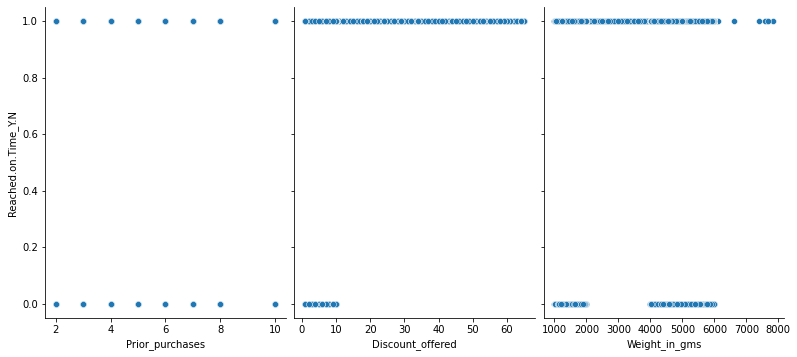

In [ ]:
plt.figure(figsize=(10,8))
sns.pairplot(data=df_shipping, x_vars=['Prior_purchases', 'Discount_offered', 'Weight_in_gms'], y_vars=['Reached.on.Time_Y.N'], size=5, aspect=0.75)

# 1. Data asli tanpa remove outlier

In [ ]:
dfori = df_shipping.copy()

dfori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Customer_care_calls      10999 non-null  int64
 1   Customer_rating          10999 non-null  int64
 2   Cost_of_the_Product      10999 non-null  int64
 3   Prior_purchases          10999 non-null  int64
 4   Discount_offered         10999 non-null  int64
 5   Weight_in_gms            10999 non-null  int64
 6   Reached.on.Time_Y.N      10999 non-null  int64
 7   Gender(num)              10999 non-null  int64
 8   Product_Importance(num)  10999 non-null  int64
 9   Warehouse_block_A        10999 non-null  uint8
 10  Warehouse_block_B        10999 non-null  uint8
 11  Warehouse_block_C        10999 non-null  uint8
 12  Warehouse_block_D        10999 non-null  uint8
 13  Mode_of_Shipment_Flight  10999 non-null  uint8
 14  Mode_of_Shipment_Road    10999 non-null  uint8
dtypes:

In [ ]:


# Model Evaluation function
def model_evaluation(model, pred, xtrain, ytrain, xtest, ytest):
    print('Accuracy : %.3f' % accuracy_score(ytest, pred))
    print('Precision : %.3f' % precision_score(ytest, pred))
    print('Recall : %.3f' % recall_score(ytest, pred))
    print('F-1Score : %.3f' % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) 
    print('ROC AUC : %.3f' % auc(fpr, tpr))
    
    # Average precision score
    average_precision = average_precision_score(ytest, pred)
    print('AP : %.3f'% average_precision)

    # Feature Importance Function
def feature_importance(model, x):
    feat_importances = pd.Series(model.best_estimator_.feature_importances_, index = x.columns)
    ax = feat_importances.nlargest(25).plot(kind = 'barh', figsize = (10, 8))
    ax.invert_yaxis()

# Best Hyperparameter Function
def best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

In [ ]:
# Splitting Features & Target
xlr1 = dfori.drop(columns = ['Reached.on.Time_Y.N']) # Features
ylr1 = dfori['Reached.on.Time_Y.N'] # Target

# Splitting Data Train & Data Test
xlrtrain1, xlrtest1, ylrtrain1, ylrtest1 = train_test_split(xlr1, ylr1, test_size = 0.3, random_state = 33)

## Logistic Regression

In [ ]:
# Modeling
modelLR1 = LogisticRegression(random_state=33)
modelLR1.fit(xlrtrain1, ylrtrain1)

LogisticRegression(random_state=33)

In [ ]:
# Model Prediction
y_pred_trainLR1 = modelLR1.predict(xlrtrain1)
y_pred_trainLR1

array([0, 1, 1, ..., 1, 1, 0])

In [ ]:
y_predLR1 = modelLR1.predict(xlrtest1)
y_predLR1

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
# Model Prediction Probability
modelLR1.predict_proba(xlrtest1)

array([[0.59004608, 0.40995392],
       [0.67207353, 0.32792647],
       [0.69585843, 0.30414157],
       ...,
       [0.47789952, 0.52210048],
       [0.46287873, 0.53712127],
       [0.57748184, 0.42251816]])

In [ ]:
# Model Evaluation
model_evaluation(modelLR1, y_predLR1, xlrtrain1, ylrtrain1, xlrtest1, ylrtest1)

Accuracy : 0.658
Precision : 0.721
Recall : 0.708
F-1Score : 0.714
ROC AUC : 0.644
AP : 0.687


In [ ]:
# Model Validation Average Precision
print('AP test score : ',average_precision_score(ylrtest1, y_predLR1))
print('AP train score : ',average_precision_score(ylrtrain1, y_pred_trainLR1))

AP test score :  0.6868098142241771
AP train score :  0.6628299951297594


In [ ]:
# Model Validation Accuracy
print('train Accuracy : ',modelLR1.score(xlrtrain1, ylrtrain1))
print('test Accuracy : ',modelLR1.score(xlrtest1, ylrtest1))

train Accuracy :  0.6307312638004936
test Accuracy :  0.6575757575757576


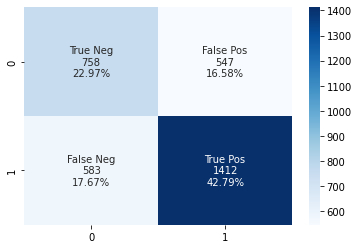

In [ ]:
# Confusion Matrix
cf_matrixa = confusion_matrix(ylrtest1, y_predLR1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrixa.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixa.flatten()/np.sum(cf_matrixa)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrixa, annot=labels, fmt='', cmap='Blues')

AP : 0.687


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.69')

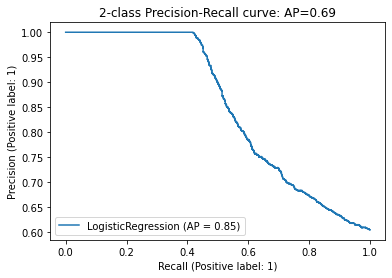

In [ ]:
# Average Precision Plot
average_precision = average_precision_score(ylrtest1, y_predLR1)
print('AP : %.3f'% average_precision)

disp = plot_precision_recall_curve(modelLR1, xlrtest1, ylrtest1)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [ ]:
# Logistic Regression Intercept
print(modelLR1.intercept_)

[0.0285722]


In [ ]:
# Logistic Regression Coefficient
print(modelLR1.coef_)

[[-0.04754708  0.07478664 -0.00034277 -0.03382388  0.11771951 -0.00015686
   0.02659305  0.07079576 -0.00124667  0.01074313  0.00310009  0.00603317
   0.01229595  0.00410358]]


In [ ]:
# Logistic Regression Coefficient Table
koef2={'Feature':['Calls', 'Rating', 'Cost', 'Purchase', 'Importance', 'Gender','Discount',
       'Weight','Warehouse_A', 'Warehouse_B', 'Warehouse_C',
       'Warehouse_D', 'Warehouse_F', 'Shipment_Flight', 'Shipment_Road',
       'Shipment_Ship'],
     'Coefficient':[-5.59874633e-01 , 1.07227510e-01, -4.16402236e-01, -5.89193486e-01,
   2.09167717e-01, -3.19677572e-02 , 6.34152939e+00 ,-1.59915957e+00,
  -2.79614790e-02  ,2.35711612e-02, -4.61884188e-03 , 4.85396819e-03,
   3.80010177e-03 , 2.21622610e-02, -8.01170261e-03, -1.45056481e-02] }
koef_table=pd.DataFrame.from_dict(koef2).sort_values(by=['Coefficient'],ascending=False).reset_index(drop=True)
koef_table

,Feature,Coefficient
0,Discount,6.341529
1,Importance,0.209168
2,Rating,0.107228
3,Warehouse_B,0.023571
4,Shipment_Flight,0.022162
5,Warehouse_D,0.004854
6,Warehouse_F,0.003800
7,Warehouse_C,-0.004619
8,Shipment_Road,-0.008012
9,Shipment_Ship,-0.014506


## Tuning Hyperparameter Logistic Regression

In [ ]:
#Tuning hyperparameter
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1','l2']
C = [0.0001,0.001,0.002]
hyperparams = dict(penalty = penalty, C=C)

lr = LogisticRegression()
rs = RandomizedSearchCV(lr, hyperparams, cv=5,random_state=42, scoring='roc_auc')
rs.fit(xlrtrain1,ylrtrain1)
y_pred = rs.predict(xlrtest1)
y_pred_proba = rs.predict_proba(xlrtest1)

from sklearn.metrics import precision_score, roc_auc_score


print("Precision (test): "+str(precision_score(ylrtest1, y_pred)))
print("Recall (test): " +str(recall_score(ylrtest1, y_pred)))
print("AUC (test): "+str(roc_auc_score(ylrtest1, y_pred_proba[:,1])))
print("AP (test): " +str(average_precision_score(ylrtest1, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Precision (test): 0.7115481593545133
Recall (test): 0.7072681704260652
AUC (test): 0.7352411680542352
AP (test): 0.6802250618063979


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

In [ ]:
y_pred_train = rs.predict(xlrtrain1)
y_pred_proba_train = rs.predict_proba(xlrtrain1)

from sklearn.metrics import precision_score, roc_auc_score
print("Precision (train): "+str(precision_score(ylrtrain1, y_pred_train)))
print("Recall (train): " +str(recall_score(ylrtrain1, y_pred_train)))
print("AUC (train): "+str(roc_auc_score(ylrtrain1, y_pred_proba_train[:,1])))
print("AP (train)" +str(average_precision_score(ylrtrain1, y_pred_train)))

Precision (train): 0.6923950056753689
Recall (train): 0.6676882661996497
AUC (train): 0.707364172522557
AP (train)0.6594724843014936


## KNN

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score #import evaluation matrix from sklearn

def eval_classification(model, Xtrain, Ytrain, Xtest, Ytest):                 #define a model evaluation function
    print("Test Data Evaluation:")
    Ypred = model.predict(Xtest)                                              #predict Y using testing data
    print("Accuracy (Test Set): %.3f" % accuracy_score(Ytest, Ypred))         #accuracy score
    print("Precision (Test Set): %.3f" % precision_score(Ytest, Ypred))       #precision score
    print("Recall (Test Set): %.3f" % recall_score(Ytest, Ypred))             #recall score
    print("F1-Score (Test Set): %.3f" % f1_score(Ytest, Ypred))               #f1 score
    
    Ypred_proba = model.predict_proba(Xtest)                                                          #predict Y (probability) using testing data 
    print("AUC (Test Set) : %.3f" % roc_auc_score(Ytest, Ypred_proba[:, 1]))                          #roc auc score
    print("Average Precision (Test Set) : %.3f" % average_precision_score(Ytest, Ypred_proba[:, 1]))  #average precision score
    print(" ")
    
    print("Train Data Evaluation:")
    Ypred_train = model.predict(Xtrain)                                          #predict Y using training data
    print("Accuracy (Train Set): %.3f" % accuracy_score(Ytrain, Ypred_train))    #accuracy score
    print("Precision (Train Set): %.3f" % precision_score(Ytrain, Ypred_train))  #precision score
    print("Recall (Train Set): %.3f" % recall_score(Ytrain, Ypred_train))        #recall score
    print("F1-Score (Train Set): %.3f" % f1_score(Ytrain, Ypred_train))          #f1 score
    Ypred_train_proba = model.predict_proba(Xtrain)                                                            #predict Y (probability) using training data
    print("AUC (Train Set) : %.3f" % roc_auc_score(Ytrain, Ypred_train_proba[:, 1]))                           #roc auc score
    print("Average Precision (Train Set) : %.3f" % average_precision_score(Ytrain, Ypred_train_proba[:, 1]))
    
               
    


In [ ]:
# train test split
xk1 = dfori.drop(columns="Reached.on.Time_Y.N")
yk1 = dfori['Reached.on.Time_Y.N']
xktrain1, xktest1, yktrain1, yktest1 = train_test_split(xk1, yk1, test_size=0.3, random_state=42)
print("training: ", xktrain1.shape[0])
print("testing: ", yktest1.shape[0])


training:  7699
testing:  3300


In [ ]:
from sklearn.neighbors import KNeighborsClassifier  #import knn from sklearn
knn = KNeighborsClassifier()                        #initialize algorithm with specified name model
knn.fit(xktrain1, yktrain1)                           #fit algorithm with train data
eval_classification(knn, xktrain1, yktrain1, xktest1, yktest1)


Test Data Evaluation:
Accuracy (Test Set): 0.652
Precision (Test Set): 0.727
Recall (Test Set): 0.676
F1-Score (Test Set): 0.701
AUC (Test Set) : 0.730
Average Precision (Test Set) : 0.815
 
Train Data Evaluation:
Accuracy (Train Set): 0.782
Precision (Train Set): 0.835
Recall (Train Set): 0.790
F1-Score (Train Set): 0.812
AUC (Train Set) : 0.868
Average Precision (Train Set) : 0.895


## Tuning Hyperparameter KNN

In [ ]:
#list of hyperparameter
n_neighbors = list(range(1,51))
p=[1,2,3]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights)

#init model
knn_model = KNeighborsClassifier()
knn_model_tun = RandomizedSearchCV(knn_model, hyperparameters, cv=5, random_state=42, scoring='roc_auc')

#fit model & evaluation
knn_model_tun.fit(xktrain1, yktrain1)
eval_classification(knn_model_tun, xktrain1, yktrain1, xktest1, yktest1)


Test Data Evaluation:
Accuracy (Test Set): 0.663
Precision (Test Set): 0.764
Recall (Test Set): 0.639
F1-Score (Test Set): 0.696
AUC (Test Set) : 0.749
Average Precision (Test Set) : 0.858
 
Train Data Evaluation:
Accuracy (Train Set): 1.000
Precision (Train Set): 1.000
Recall (Train Set): 1.000
F1-Score (Train Set): 1.000
AUC (Train Set) : 1.000
Average Precision (Train Set) : 1.000


In [ ]:
# best param
knn_model_tun.best_params_


{'algorithm': 'auto', 'n_neighbors': 21, 'p': 1, 'weights': 'distance'}

## Decision Tree

In [ ]:

# train test split
X = dfori.drop(columns="Reached.on.Time_Y.N")
y = dfori['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])




training:  7699
testing:  3300


In [ ]:
from sklearn.tree import DecisionTreeClassifier       #import decision tree from sklearn
dt = DecisionTreeClassifier(random_state=42)     #initialize algorithm with specified name model
dt.fit(X_train, y_train)                         #fit algorithm with train data
eval_classification(dt, X_train, y_train, X_test, y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.655
Precision (Test Set): 0.713
Recall (Test Set): 0.715
F1-Score (Test Set): 0.714
AUC (Test Set) : 0.639
Average Precision (Test Set) : 0.681
 
Train Data Evaluation:
Accuracy (Train Set): 1.000
Precision (Train Set): 1.000
Recall (Train Set): 1.000
F1-Score (Train Set): 1.000
AUC (Train Set) : 1.000
Average Precision (Train Set) : 1.000


## Tuning Hyperparmater Decision Tree

In [ ]:
#list of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] #maximum number of levels in tree
min_samples_split = [2, 5, 10, 100, 200] #minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50, 100] #minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt', 'log2'] #number of features to consider at every split
criterion = ['gini', 'entropy'] #the function to measure the quality of a split
splitter = ['best', 'random'] #the strategy used to choose the split at each node

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )


In [ ]:
#initiate model
dt = DecisionTreeClassifier(random_state=42)
dt_tun = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
dt_tun.fit(X_train, y_train) #fit model

eval_classification(dt_tun, X_train, y_train, X_test, y_test)


Test Data Evaluation:
Accuracy (Test Set): 0.666
Precision (Test Set): 0.787
Recall (Test Set): 0.611
F1-Score (Test Set): 0.688
AUC (Test Set) : 0.731
Average Precision (Test Set) : 0.837
 
Train Data Evaluation:
Accuracy (Train Set): 0.681
Precision (Train Set): 0.796
Recall (Train Set): 0.624
F1-Score (Train Set): 0.699
AUC (Train Set) : 0.759
Average Precision (Train Set) : 0.848


In [ ]:
dt_tun.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 20,
 'min_samples_split': 100,
 'splitter': 'best'}

## XGBoost

In [ ]:
# Splitting Features & Target
xlr2 = dfori.drop(columns = ['Reached.on.Time_Y.N']) # Features
ylr2 = dfori['Reached.on.Time_Y.N'] # Target

# Splitting data Train & data Test
xltrain2, xltest2, yltrain2, yltest2 = train_test_split(xlr2, ylr2, test_size = 0.3, random_state = 3)

In [ ]:
model_xg = XGBClassifier(random_state = 42)
model_xg.fit(xltrain2,yltrain2)
eval_classification(model_xg, xltrain2, yltrain2, xltest2, yltest2)


Test Data Evaluation:
Accuracy (Test Set): 0.685
Precision (Test Set): 0.881
Recall (Test Set): 0.537
F1-Score (Test Set): 0.667
AUC (Test Set) : 0.734
Average Precision (Test Set) : 0.848
 
Train Data Evaluation:
Accuracy (Train Set): 0.706
Precision (Train Set): 0.907
Recall (Train Set): 0.568
F1-Score (Train Set): 0.699
AUC (Train Set) : 0.802
Average Precision (Train Set) : 0.885


In [ ]:
# Model Prediction
predictionl2_train = XGl2.predict(xltrain2)
predictionl2_train

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
# Model Validation Average Precision
print('AP train: ',average_precision_score(yltrain2, predictionl2_train))
print('AP test: ',average_precision_score(yltest2, predictionl2))

AP train:  0.7747266005987892
AP test:  0.7452168714182988


In [ ]:
# Model Validation Accuracy
print('train Accuracy : ',XGl2.score(xltrain2, yltrain2))
print('test Accuracy : ',XGl2.score(xltest2, yltest2))

train Accuracy :  0.7056760618262112
test Accuracy :  0.6851515151515152


## Tuning Hyperparameter XGBoost

In [ ]:
# Splitting Features & Target
xl3 = dfori.drop(columns = ['Reached.on.Time_Y.N'])
yl3 = dfori['Reached.on.Time_Y.N']

# Splitting Data Train & Data Test
xltrain3, xltest3, yltrain3, yltest3 = train_test_split(xl3, yl3, test_size = 0.3, random_state = 42)

In [ ]:
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],
                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],
                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, random_state=42, cv=5, scoring='roc_auc')
xg_tuned.fit(xltrain3,yltrain3)
eval_classification(xg_tuned, xltrain3, yltrain3, xltest3, yltest3)

Test Data Evaluation:
Accuracy (Test Set): 0.662
Precision (Test Set): 0.766
Recall (Test Set): 0.633
F1-Score (Test Set): 0.693
AUC (Test Set) : 0.744
Average Precision (Test Set) : 0.857
 
Train Data Evaluation:
Accuracy (Train Set): 0.788
Precision (Train Set): 0.887
Recall (Train Set): 0.736
F1-Score (Train Set): 0.804
AUC (Train Set) : 0.883
Average Precision (Train Set) : 0.928


In [ ]:
# best param
xg_tuned.best_params_

{'alpha': 0.8,
 'colsample_bytree': 0.30000000000000004,
 'eta': 0.33333333333333337,
 'gamma': 0.5,
 'lambda': 0.8,
 'max_depth': 50,
 'min_child_weight': 18,
 'tree_method': 'approx'}

In [ ]:
# Evaluation Metrics
ABl3 = AdaBoostClassifier(random_state = 3)
ABl3.fit(xltrain3, yltrain3)
predictionl3 = ABl3.predict(xltest3)
model_evaluation(ABl3, predictionl3, xltrain3, yltrain3, xltest3, yltest3)

Accuracy : 0.676
Precision : 0.804
Recall : 0.610
F-1Score : 0.694
ROC AUC : 0.693
AP : 0.726


In [ ]:
# Model Prediction
predictionl3_train = ABl3.predict(xltrain3)
predictionl3_train

array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
# Model Validation Average Precision
print('AP train: ',average_precision_score(yltrain3, predictionl3_train))
print('AP test: ',average_precision_score(yltest3, predictionl3))

AP train:  0.7265358329163607
AP test:  0.7256477232497145


In [ ]:
# Model Validation Accuracy
print('train Accuracy : ',ABl3.score(xltrain3, yltrain3))
print('test Accuracy : ',ABl3.score(xltest3, yltest3))

train Accuracy :  0.6847642550980647
test Accuracy :  0.6757575757575758


## AdaBoost

In [ ]:
# train test split
X = dfori.drop(columns="Reached.on.Time_Y.N")
y = dfori['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])


training:  7699
testing:  3300


In [ ]:
model_ab = AdaBoostClassifier()
model_ab.fit(X_train,y_train)
eval_classification(model_ab, X_train, y_train, X_test, y_test)



Test Data Evaluation:
Accuracy (Test Set): 0.676
Precision (Test Set): 0.804
Recall (Test Set): 0.610
F1-Score (Test Set): 0.694
AUC (Test Set) : 0.748
Average Precision (Test Set) : 0.859
 
Train Data Evaluation:
Accuracy (Train Set): 0.685
Precision (Train Set): 0.810
Recall (Train Set): 0.614
F1-Score (Train Set): 0.698
AUC (Train Set) : 0.765
Average Precision (Train Set) : 0.863


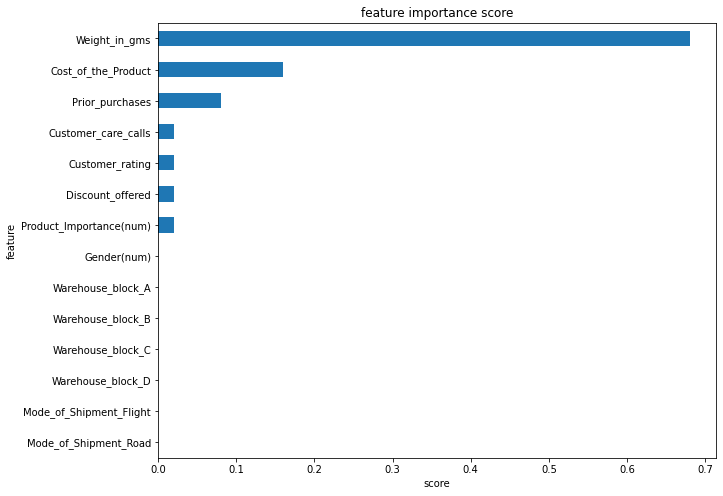

In [ ]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

show_feature_importance(model_ab)

## Tuning Hyperparameter AdaBoost

In [ ]:
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 2000)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 200)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )


In [ ]:
# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned = RandomizedSearchCV(ab, hyperparameters, random_state=42, cv=5, scoring='roc_auc')
ab_tuned.fit(X_train,y_train)
eval_classification(ab_tuned, X_train, y_train, X_test, y_test)



Test Data Evaluation:
Accuracy (Test Set): 0.678
Precision (Test Set): 0.815
Recall (Test Set): 0.604
F1-Score (Test Set): 0.693
AUC (Test Set) : 0.744
Average Precision (Test Set) : 0.854
 
Train Data Evaluation:
Accuracy (Train Set): 0.680
Precision (Train Set): 0.811
Recall (Train Set): 0.600
F1-Score (Train Set): 0.690
AUC (Train Set) : 0.755
Average Precision (Train Set) : 0.855


In [ ]:
# best param
ab_tuned.best_params_


{'algorithm': 'SAMME.R',
 'learning_rate': 0.08358291457286432,
 'n_estimators': 225}

## Random Forest

In [ ]:
# Splitting Features & Target
xr4 = dfori.drop(columns = ['Reached.on.Time_Y.N'])
yr4 = dfori['Reached.on.Time_Y.N']

# Splitting Data Train & Data Test
xrtrain4, xrtest4, yrtrain4, yrtest4 = train_test_split(xr4, yr4, test_size = 0.3, random_state = 10)

In [ ]:
# Evaluation Metrics
RFr4 = RandomForestClassifier(random_state = 42)
RFr4.fit(xrtrain4, yrtrain4)
predictionr4 = RFr4.predict(xrtest4)
model_evaluation(RFr4, predictionr4, xrtrain4, yrtrain4, xrtest4, yrtest4)

Accuracy : 0.659
Precision : 0.754
Recall : 0.641
F-1Score : 0.693
ROC AUC : 0.664
AP : 0.699


In [ ]:
model_rf = RandomForestClassifier(random_state =42)
model_rf.fit(xrtrain4,yrtrain4)
eval_classification(model_rf, xrtrain4, yrtrain4, xrtest4, yrtest4)


Test Data Evaluation:
Accuracy (Test Set): 0.659
Precision (Test Set): 0.754
Recall (Test Set): 0.641
F1-Score (Test Set): 0.693
AUC (Test Set) : 0.735
Average Precision (Test Set) : 0.851
 
Train Data Evaluation:
Accuracy (Train Set): 1.000
Precision (Train Set): 1.000
Recall (Train Set): 1.000
F1-Score (Train Set): 1.000
AUC (Train Set) : 1.000
Average Precision (Train Set) : 1.000


In [ ]:
# Model Validation Accuracy
print('train Accuracy : ', RFr4.score(xrtrain4, yrtrain4))
print('test Accuracy : ', RFr4.score(xrtest4, yrtest4))

train Accuracy :  1.0
test Accuracy :  0.6593939393939394


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


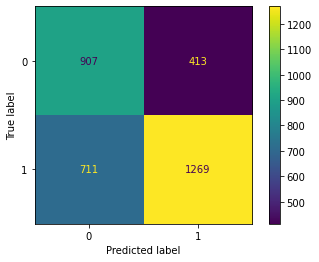

In [ ]:
# Confusion Matrix
plot_confusion_matrix(RFr4, xrtest4, yrtest4)
plt.grid(False)
plt.show() 

## Tuning Hyperparameter Random Forest

In [ ]:
hyperparameters_rf = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], #the number of features to consider when looking for the best split
                       n_jobs = [-1] #the number of jobs to run in parallel computation. -1 means using all processors
                      )

# Init
rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters_rf, cv=5, random_state=42, scoring='roc_auc')
rf_tuned.fit(xrtrain4,yrtrain4)
eval_classification(rf_tuned, xrtrain4, yrtrain4, xrtest4, yrtest4)


Test Data Evaluation:
Accuracy (Test Set): 0.671
Precision (Test Set): 0.830
Recall (Test Set): 0.568
F1-Score (Test Set): 0.674
AUC (Test Set) : 0.737
Average Precision (Test Set) : 0.853
 
Train Data Evaluation:
Accuracy (Train Set): 0.822
Precision (Train Set): 0.959
Recall (Train Set): 0.732
F1-Score (Train Set): 0.830
AUC (Train Set) : 0.953
Average Precision (Train Set) : 0.967


In [ ]:
# best param
rf_tuned.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 8,
 'n_estimators': 300,
 'n_jobs': -1}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


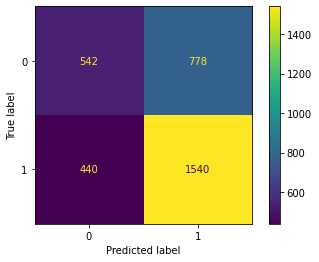

In [ ]:
# Model Validation Average Precision
plot_confusion_matrix(RFHr4, xrtest4, yrtest4)
plt.grid(False)
plt.show() 

# 2. Data dengan Log Transfirmation

In [ ]:
df_log = df_shipping.copy()

df_log.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Gender(num),Product_Importance(num),Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Mode_of_Shipment_Flight,Mode_of_Shipment_Road
0,4,2,177,3,44,1233,1,0,0,0,0,0,1,1,0
1,4,5,216,2,59,3088,1,1,0,0,0,0,0,1,0
2,2,2,183,4,48,3374,1,1,0,1,0,0,0,1,0
3,3,3,176,4,10,1177,1,1,1,0,1,0,0,1,0
4,2,2,184,3,46,2484,1,0,1,0,0,1,0,1,0


In [ ]:
#tranformasi log
df_log['log_Discount_Offered'] = np.log(df_shipping['Discount_offered'])
df_log['log_Prior_Purchases'] = np.log(df_shipping['Prior_purchases'])

In [ ]:
df_log[{'Discount_offered', 'log_Discount_Offered', 'Prior_purchases', 'log_Prior_Purchases'}].describe()

,Prior_purchases,log_Prior_Purchases,Discount_offered,log_Discount_Offered
count,10999.000000,10999.000000,10999.000000,10999.000000
mean,3.567597,1.195669,13.373216,1.998420
std,1.522860,0.379769,16.205527,1.083692
min,2.000000,0.693147,1.000000,0.000000
25%,3.000000,1.098612,4.000000,1.386294
50%,3.000000,1.098612,7.000000,1.945910
75%,4.000000,1.386294,10.000000,2.302585
max,10.000000,2.302585,65.000000,4.174387


In [ ]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_care_calls      10999 non-null  int64  
 1   Customer_rating          10999 non-null  int64  
 2   Cost_of_the_Product      10999 non-null  int64  
 3   Prior_purchases          10999 non-null  int64  
 4   Discount_offered         10999 non-null  int64  
 5   Weight_in_gms            10999 non-null  int64  
 6   Reached.on.Time_Y.N      10999 non-null  int64  
 7   Gender(num)              10999 non-null  int64  
 8   Product_Importance(num)  10999 non-null  int64  
 9   Warehouse_block_A        10999 non-null  uint8  
 10  Warehouse_block_B        10999 non-null  uint8  
 11  Warehouse_block_C        10999 non-null  uint8  
 12  Warehouse_block_D        10999 non-null  uint8  
 13  Mode_of_Shipment_Flight  10999 non-null  uint8  
 14  Mode_of_Shipment_Road 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def eval_classification(model, xtrain, ytrain, xtest, ytest):
    ypred = model.predict(xtest)
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, ypred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, ypred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, ypred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, ypred))
    
    y_pred_proba = model.predict_proba(xtest)
    print("AUC: %.2f" % roc_auc_score(ytest, y_pred_proba[:, 1]))
    
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

In [ ]:
df_log.columns

Index(['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
       'Prior_purchases', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N', 'Gender(num)', 'Product_Importance(num)',
       'Warehouse_block_A', 'Warehouse_block_B', 'Warehouse_block_C',
       'Warehouse_block_D', 'Mode_of_Shipment_Flight', 'Mode_of_Shipment_Road',
       'log_Discount_Offered', 'log_Prior_Purchases'],
      dtype='object')

In [ ]:
# Split Feature and Label
X = df_log.drop(columns=['Prior_purchases','Discount_offered','Reached.on.Time_Y.N'])
y = df_log['Reached.on.Time_Y.N'] # target / label

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
df_log.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Gender(num),Product_Importance(num),Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,log_Discount_Offered,log_Prior_Purchases
0,4,2,177,3,44,1233,1,0,0,0,0,0,1,1,0,3.784190,1.098612
1,4,5,216,2,59,3088,1,1,0,0,0,0,0,1,0,4.077537,0.693147
2,2,2,183,4,48,3374,1,1,0,1,0,0,0,1,0,3.871201,1.386294
3,3,3,176,4,10,1177,1,1,1,0,1,0,0,1,0,2.302585,1.386294
4,2,2,184,3,46,2484,1,0,1,0,0,1,0,1,0,3.828641,1.098612


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
model.predict_proba(X_test)

array([[0.11664102, 0.88335898],
       [0.55406694, 0.44593306],
       [0.58351776, 0.41648224],
       ...,
       [0.43820925, 0.56179075],
       [0.20658171, 0.79341829],
       [0.42661425, 0.57338575]])

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_train

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
eval_classification(model, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.63
Precision (Test Set): 0.67
Recall (Test Set): 0.75
F1-Score (Test Set): 0.71
AUC: 0.71


In [ ]:
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))

Precision (Train Set): 0.67


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 0.6265748798545265
Test score:0.6293939393939394


## Hyperparameter Tuning

In [ ]:
# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C)

# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
model = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='precision')

# Fitting Model & Evaluation
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
eval_classification(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the dat

Accuracy (Test Set): 0.63
Precision (Test Set): 0.67
Recall (Test Set): 0.76
F1-Score (Test Set): 0.71
AUC: 0.72


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

In [ ]:
y_pred_train = model.predict(X_train)
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))

Precision (Train Set): 0.67


In [ ]:
print('Best penalty:', model.best_estimator_.get_params()['penalty'])
print('Best C:', model.best_estimator_.get_params()['C'])

Best penalty: l2
Best C: 0.002


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 0.6659607239122064
Test score:0.6690391459074733


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
eval_classification(model, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.66
Precision (Test Set): 0.72
Recall (Test Set): 0.72
F1-Score (Test Set): 0.72
AUC: 0.64


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 1.0
Test score:0.6575757575757576


## Hyperparameter Tuning with RandomSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='precision')
model.fit(X_train, y_train)

# Predict & Evaluation
y_pred = model.predict(X_test)#Check performa dari model
eval_classification(model, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.66
Precision (Test Set): 0.76
Recall (Test Set): 0.62
F1-Score (Test Set): 0.69
AUC: 0.73


In [ ]:
print('Best max_depth:', model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', model.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', model.best_estimator_.get_params()['max_features'])

Best max_depth: 8
Best min_samples_split: 5
Best min_samples_leaf: 1
Best max_features: sqrt


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train)))
print('Test score:' + str(model.score(X_test, y_test)))

Train score: 0.8168449197860963
Test score:0.761817065684469


Text(0.5, 1.0, 'feature importance score')

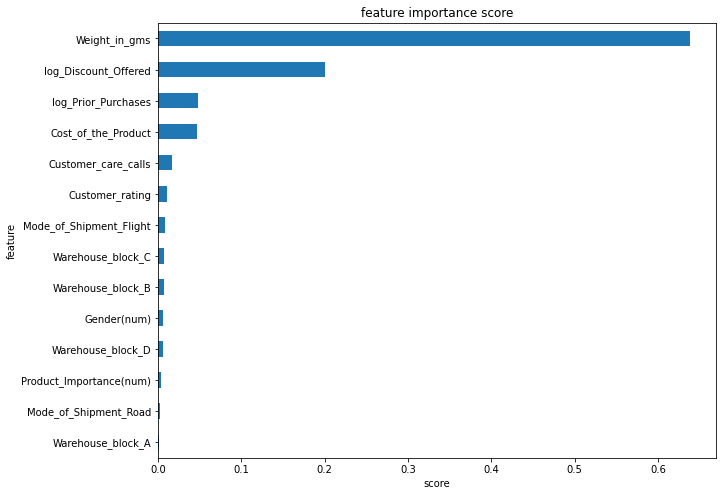

In [ ]:
# plt.figsize(10, 8)
feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

## Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
eval_classification(rf, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.66
Precision (Test Set): 0.76
Recall (Test Set): 0.64
F1-Score (Test Set): 0.69
AUC: 0.74


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 0.8168449197860963
Test score:0.761817065684469


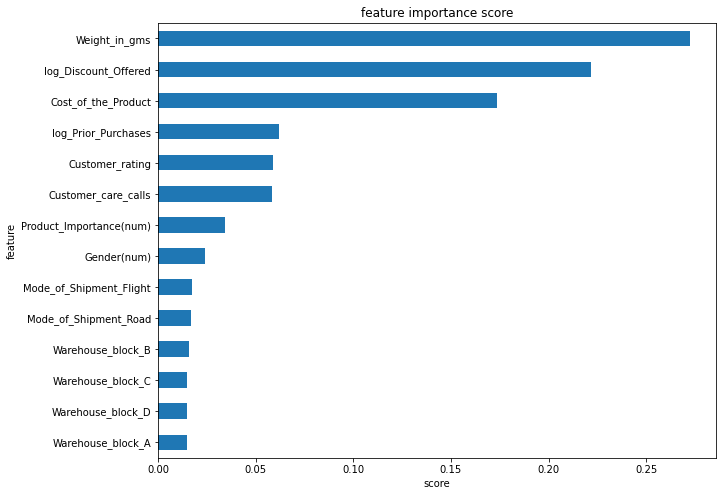

In [ ]:
show_feature_importance(rf)

## Hyperparameter yang biasa di tuning pada Random Forest

In [ ]:
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='recall')
rf_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(rf_tuned, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.66
Precision (Test Set): 0.77
Recall (Test Set): 0.63
F1-Score (Test Set): 0.69
AUC: 0.74


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 0.8168449197860963
Test score:0.761817065684469


In [ ]:
show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)

Best n_estimators: 400
Best bootstrap: True
Best criterion: gini
Best max_depth: 110
Best min_samples_split: 4
Best min_samples_leaf: 1
Best max_features: log2
Best n_jobs: -1


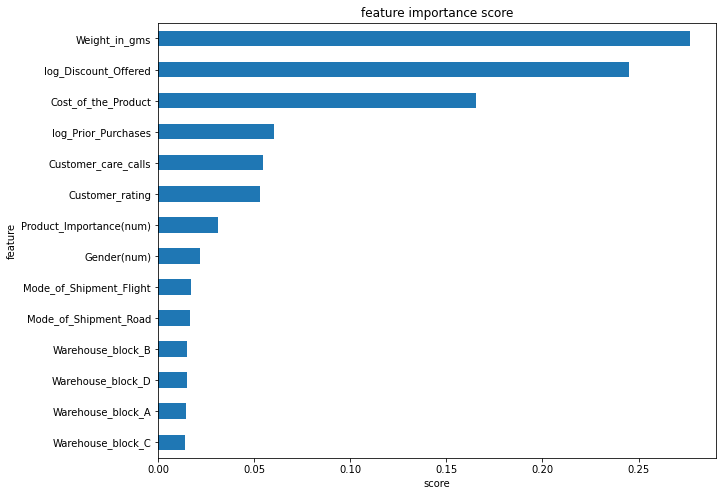

In [ ]:
show_feature_importance(rf_tuned.best_estimator_)

## AdaBost

In [ ]:
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train,y_train)

eval_classification(ab, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.68
Precision (Test Set): 0.80
Recall (Test Set): 0.61
F1-Score (Test Set): 0.69
AUC: 0.75


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 0.8168449197860963
Test score:0.761817065684469


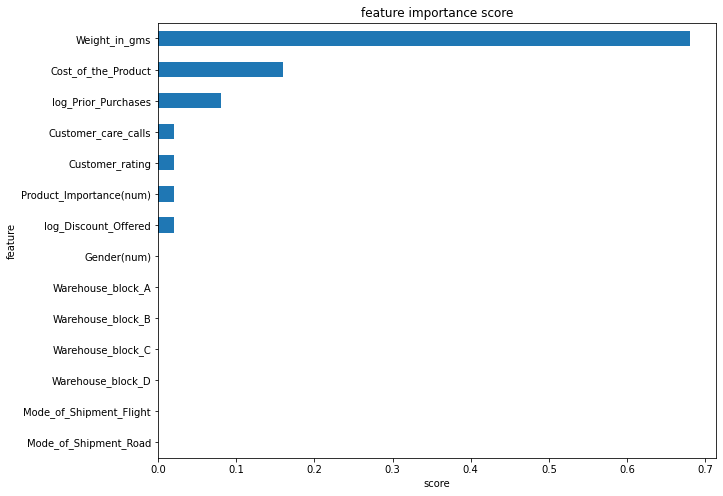

In [ ]:
show_feature_importance(ab)

## Hyperparameter yang biasa di tuning pada Adaboost

In [ ]:
# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 2000)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 200)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned = RandomizedSearchCV(ab, hyperparameters, random_state=42, cv=5, scoring='recall')
ab_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(ab_tuned, X_train, y_train, X_test, y_test)

In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

In [ ]:
show_best_hyperparameter(ab_tuned.best_estimator_, hyperparameters)

In [ ]:
show_feature_importance(ab_tuned.best_estimator_)

## XGBoost

In [ ]:
xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)

eval_classification(xg, X_train, y_train, X_test, y_test)

In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

In [ ]:
show_feature_importance(xg)

## Hyperparameter yang umum di tuning pada XGBoost

In [ ]:
#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(xg_tuned, X_train, y_train, X_test, y_test)

In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

In [ ]:
show_best_hyperparameter(xg_tuned.best_estimator_, hyperparameters)

In [ ]:
show_feature_importance(xg_tuned.best_estimator_)

# 3. Remove outlier using IQR Discount

In [ ]:
new_num_col = df_shipping.columns.to_list()

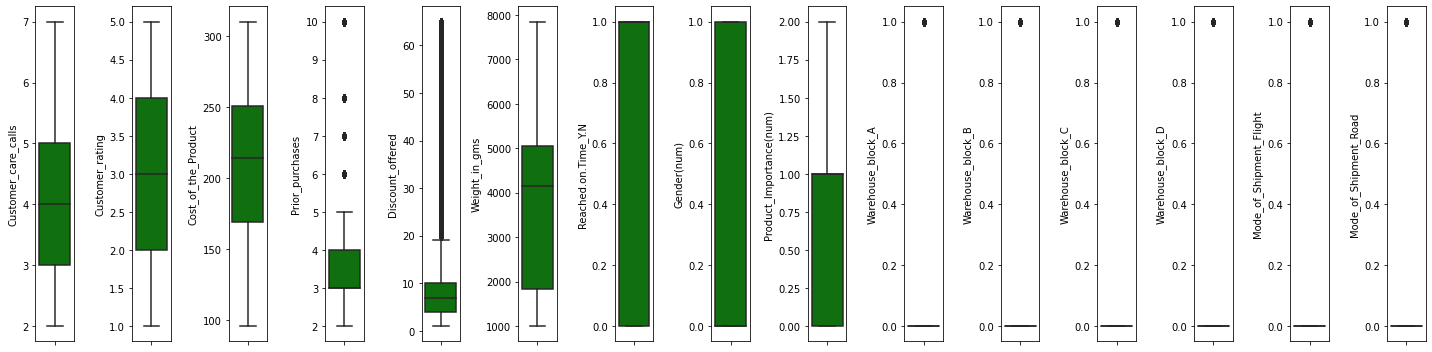

In [ ]:
plt.figure(figsize=(20,5))
for i in range(0, len(new_num_col)):
  plt.subplot(1, len(new_num_col), i+1)
  sns.boxplot(y=df_shipping[new_num_col[i]], color='green', orient='v')
  plt.tight_layout()

In [ ]:
df_remot = df_shipping.copy()

Q1 = df_remot['Discount_offered'].quantile(0.25)
Q3 = df_remot['Discount_offered'].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)
filtered_entries = ((df_remot['Discount_offered'] >= low_limit) & (df_remot['Discount_offered'] <= high_limit))
df_remot = df_remot[filtered_entries]

In [ ]:
df_remot.shape

(8790, 15)

In [ ]:
df_remot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8790 entries, 3 to 10998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Customer_care_calls      8790 non-null   int64
 1   Customer_rating          8790 non-null   int64
 2   Cost_of_the_Product      8790 non-null   int64
 3   Prior_purchases          8790 non-null   int64
 4   Discount_offered         8790 non-null   int64
 5   Weight_in_gms            8790 non-null   int64
 6   Reached.on.Time_Y.N      8790 non-null   int64
 7   Gender(num)              8790 non-null   int64
 8   Product_Importance(num)  8790 non-null   int64
 9   Warehouse_block_A        8790 non-null   uint8
 10  Warehouse_block_B        8790 non-null   uint8
 11  Warehouse_block_C        8790 non-null   uint8
 12  Warehouse_block_D        8790 non-null   uint8
 13  Mode_of_Shipment_Flight  8790 non-null   uint8
 14  Mode_of_Shipment_Road    8790 non-null   uint8
dtypes: 

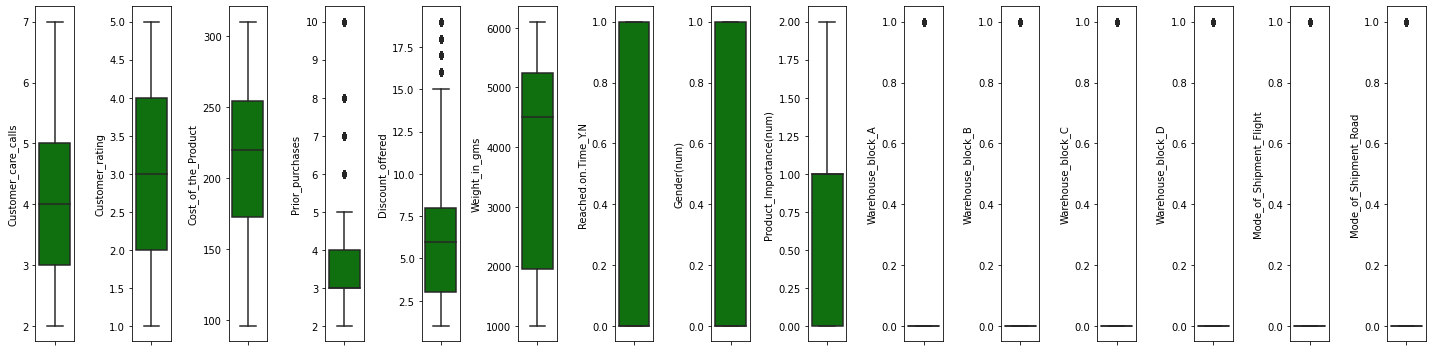

In [ ]:
new_nums_col = df_remot.columns.to_list()

plt.figure(figsize=(20,5))
for i in range(0, len(new_nums_col)):
  plt.subplot(1, len(new_nums_col), i+1)
  sns.boxplot(y=df_remot[new_nums_col[i]], color='green', orient='v')
  plt.tight_layout()

In [ ]:
df_remot['Reached.on.Time_Y.N'].value_counts()

0    4436
1    4354
Name: Reached.on.Time_Y.N, dtype: int64

In [ ]:
df_remot.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Gender(num),Product_Importance(num),Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Mode_of_Shipment_Flight,Mode_of_Shipment_Road
count,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000
mean,4.129693,2.991468,213.739590,3.632309,5.975085,3951.409556,0.495336,0.498976,0.595449,0.168032,0.167122,0.166325,0.169056,0.162230,0.159613
std,1.164683,1.410038,48.075808,1.513681,3.523850,1620.529287,0.500007,0.500027,0.635848,0.373916,0.373106,0.372394,0.374822,0.368682,0.366268
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,173.000000,3.000000,3.000000,1949.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,220.000000,3.000000,6.000000,4512.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,254.000000,4.000000,8.000000,5243.750000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,5.000000,310.000000,10.000000,19.000000,6102.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

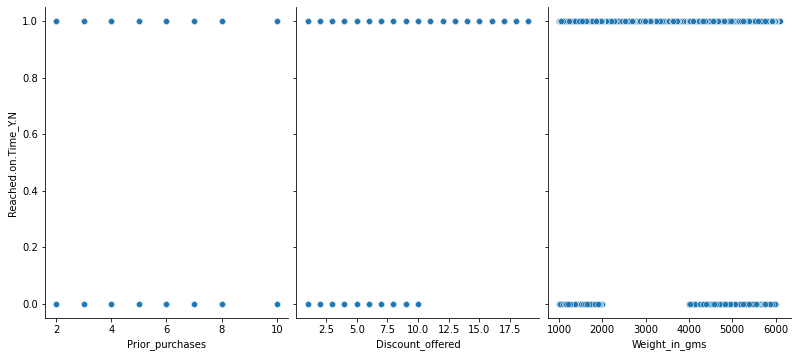

In [ ]:
plt.figure(figsize=(10,8))
sns.pairplot(data=df_remot, x_vars=['Prior_purchases', 'Discount_offered', 'Weight_in_gms'], y_vars=['Reached.on.Time_Y.N'], size=5, aspect=0.75)

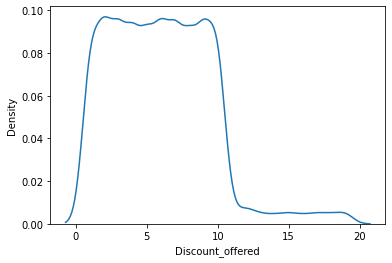

In [ ]:
sns.kdeplot(df_remot['Discount_offered'])

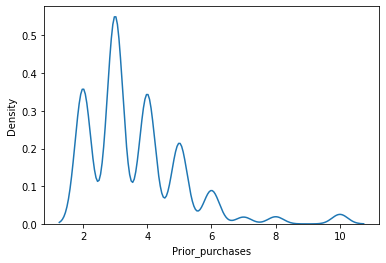

In [ ]:
sns.kdeplot(df_remot['Prior_purchases'])

## Normalisasi dengan MinMaxScaller

In [ ]:
df_remot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8790 entries, 3 to 10998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Customer_care_calls      8790 non-null   int64
 1   Customer_rating          8790 non-null   int64
 2   Cost_of_the_Product      8790 non-null   int64
 3   Prior_purchases          8790 non-null   int64
 4   Discount_offered         8790 non-null   int64
 5   Weight_in_gms            8790 non-null   int64
 6   Reached.on.Time_Y.N      8790 non-null   int64
 7   Gender(num)              8790 non-null   int64
 8   Product_Importance(num)  8790 non-null   int64
 9   Warehouse_block_A        8790 non-null   uint8
 10  Warehouse_block_B        8790 non-null   uint8
 11  Warehouse_block_C        8790 non-null   uint8
 12  Warehouse_block_D        8790 non-null   uint8
 13  Mode_of_Shipment_Flight  8790 non-null   uint8
 14  Mode_of_Shipment_Road    8790 non-null   uint8
dtypes: 

In [ ]:
tipe_data_df = ['int64', 'uint8']
num_df_remot = df_remot.select_dtypes(include = tipe_data_df)
nums_data_col = num_df_remot.columns
print(nums_data_col)

Index(['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
       'Prior_purchases', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N', 'Gender(num)', 'Product_Importance(num)',
       'Warehouse_block_A', 'Warehouse_block_B', 'Warehouse_block_C',
       'Warehouse_block_D', 'Mode_of_Shipment_Flight',
       'Mode_of_Shipment_Road'],
      dtype='object')


In [ ]:
for i in range(len(nums_data_col)):
    df_remot[nums_data_col[i]] = MinMaxScaler().fit_transform(df_remot[nums_data_col[i]].values.reshape(len(df_remot), 1))

In [ ]:
df_remot.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Gender(num),Product_Importance(num),Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Mode_of_Shipment_Flight,Mode_of_Shipment_Road
3,0.2,0.50,0.373832,0.250,0.500000,0.034503,1.0,1.0,0.5,0.0,1.0,0.0,0.0,1.0,0.0
5,0.2,0.00,0.308411,0.125,0.611111,0.081553,1.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0
6,0.2,0.75,0.719626,0.125,0.111111,0.268575,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
8,0.2,0.75,0.252336,0.125,0.555556,0.168594,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
10,0.2,0.75,0.434579,0.000,0.611111,0.369927,1.0,1.0,0.5,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
df_remot['Reached.on.Time_Y.N'].value_counts(normalize=True)

0.0    0.504664
1.0    0.495336
Name: Reached.on.Time_Y.N, dtype: float64

## Model Evaluasion

In [ ]:
#model evaluation automatization function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score #import evaluation matrix from sklearn

def eval_classification(model, Xtrain, Ytrain, Xtest, Ytest):                 #define a model evaluation function
    print("Test Data Evaluation:")
    Ypred = model.predict(Xtest)                                              #predict Y using testing data
    print("Accuracy (Test Set): %.3f" % accuracy_score(Ytest, Ypred))         #accuracy score
    print("Precision (Test Set): %.3f" % precision_score(Ytest, Ypred))       #precision score
    print("Recall (Test Set): %.3f" % recall_score(Ytest, Ypred))             #recall score
    print("F1-Score (Test Set): %.3f" % f1_score(Ytest, Ypred))               #f1 score
    
    Ypred_proba = model.predict_proba(Xtest)                                                          #predict Y (probability) using testing data 
    print("AUC (Test Set) : %.3f" % roc_auc_score(Ytest, Ypred_proba[:, 1]))                          #roc auc score
    print("Average Precision (Test Set) : %.3f" % average_precision_score(Ytest, Ypred_proba[:, 1]))  #average precision score
    print(" ")
    
    print("Train Data Evaluation:")
    Ypred_train = model.predict(Xtrain)                                          #predict Y using training data
    print("Accuracy (Train Set): %.3f" % accuracy_score(Ytrain, Ypred_train))    #accuracy score
    print("Precision (Train Set): %.3f" % precision_score(Ytrain, Ypred_train))  #precision score
    print("Recall (Train Set): %.3f" % recall_score(Ytrain, Ypred_train))        #recall score
    print("F1-Score (Train Set): %.3f" % f1_score(Ytrain, Ypred_train))          #f1 score
    
    Ypred_train_proba = model.predict_proba(Xtrain)                                                            #predict Y (probability) using training data
    print("AUC (Train Set) : %.3f" % roc_auc_score(Ytrain, Ypred_train_proba[:, 1]))                           #roc auc score
    print("Average Precision (Train Set) : %.3f" % average_precision_score(Ytrain, Ypred_train_proba[:, 1]))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

### Logistic Regression

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

training:  7699
testing:  3300


In [ ]:
model_log_reg = LogisticRegression()
model_log_reg.fit(X_train, y_train)
eval_classification(model_log_reg, X_train, y_train, X_test, y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.635
Precision (Test Set): 0.709
Recall (Test Set): 0.668
F1-Score (Test Set): 0.688
AUC (Test Set) : 0.712
Average Precision (Test Set) : 0.835
 
Train Data Evaluation:
Accuracy (Train Set): 0.637
Precision (Train Set): 0.707
Recall (Train Set): 0.666
F1-Score (Train Set): 0.686
AUC (Train Set) : 0.716
Average Precision (Train Set) : 0.833


### KNN

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

training:  7699
testing:  3300


In [ ]:
from sklearn.neighbors import KNeighborsClassifier  #import knn from sklearn
knn = KNeighborsClassifier()                        #initialize algorithm with specified name model
knn.fit(X_train, y_train)                           #fit algorithm with train data
eval_classification(knn, X_train, y_train, X_test, y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.652
Precision (Test Set): 0.727
Recall (Test Set): 0.676
F1-Score (Test Set): 0.701
AUC (Test Set) : 0.730
Average Precision (Test Set) : 0.815
 
Train Data Evaluation:
Accuracy (Train Set): 0.782
Precision (Train Set): 0.835
Recall (Train Set): 0.790
F1-Score (Train Set): 0.812
AUC (Train Set) : 0.868
Average Precision (Train Set) : 0.895


### Random Forest

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

training:  7699
testing:  3300


In [ ]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train,y_train)
eval_classification(model_rf, X_train, y_train, X_test, y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.663
Precision (Test Set): 0.764
Recall (Test Set): 0.636
F1-Score (Test Set): 0.694
AUC (Test Set) : 0.739
Average Precision (Test Set) : 0.853
 
Train Data Evaluation:
Accuracy (Train Set): 1.000
Precision (Train Set): 1.000
Recall (Train Set): 1.000
F1-Score (Train Set): 1.000
AUC (Train Set) : 1.000
Average Precision (Train Set) : 1.000


### Decission Tree

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

In [ ]:
from sklearn.tree import DecisionTreeClassifier       #import decision tree from sklearn
dt = DecisionTreeClassifier(random_state=42)     #initialize algorithm with specified name model
dt.fit(X_train, y_train)                         #fit algorithm with train data
eval_classification(dt, X_train, y_train, X_test, y_test)

### XGBoost

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
eval_classification(model_xgb, X_train, y_train, X_test, y_test)

### Adaboost

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

In [ ]:
model_ab = AdaBoostClassifier()
model_ab.fit(X_train,y_train)
eval_classification(model_ab, X_train, y_train, X_test, y_test)

## Model dengan tunning hyperparam

### Logistic Regression

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

In [ ]:
penalty = ['l1', 'l2']
C = [0.00001, 0.0001, 0.001, 0.01, 0.1]
hyperparameters_logreg = dict(penalty=penalty, C=C)
model_logreg = LogisticRegression()
model_logreg_tun = GridSearchCV(model_logreg, hyperparameters_logreg, cv=5, scoring='roc_auc')
model_logreg_tun.fit(X_train, y_train)
eval_classification(model_logreg_tun, X_train, y_train, X_test, y_test)

In [ ]:
# best param
model_logreg_tun.best_params_

### KNN

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

In [ ]:
#list of hyperparameter
n_neighbors = list(range(1,51))
p=[1,2,3]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights)

#init model
knn_model = KNeighborsClassifier()
knn_model_tun = RandomizedSearchCV(knn_model, hyperparameters, cv=5, random_state=42, scoring='roc_auc')

#fit model & evaluation
knn_model_tun.fit(X_train, y_train)
eval_classification(knn_model_tun, X_train, y_train, X_test, y_test)

In [ ]:
# best param
knn_model_tun.best_params_

### Random Forest

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

In [ ]:
hyperparameters_rf = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], #the number of features to consider when looking for the best split
                       n_jobs = [-1] #the number of jobs to run in parallel computation. -1 means using all processors
                      )

# Init
rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters_rf, cv=5, random_state=42, scoring='roc_auc')
rf_tuned.fit(X_train,y_train)
eval_classification(rf_tuned, X_train, y_train, X_test, y_test)


Test Data Evaluation:
Accuracy (Test Set): 0.677
Precision (Test Set): 0.865
Recall (Test Set): 0.550
F1-Score (Test Set): 0.673
AUC (Test Set) : 0.738
Average Precision (Test Set) : 0.855
 
Train Data Evaluation:
Accuracy (Train Set): 0.772
Precision (Train Set): 0.952
Recall (Train Set): 0.650
F1-Score (Train Set): 0.772
AUC (Train Set) : 0.914
Average Precision (Train Set) : 0.944


In [ ]:
# best param
rf_tuned.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'min_samples_split': 8,
 'n_estimators': 100,
 'n_jobs': -1}

### Decission Tree

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

training:  7699
testing:  3300


In [ ]:
#list of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] #maximum number of levels in tree
min_samples_split = [2, 5, 10, 100, 200] #minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50, 100] #minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt', 'log2'] #number of features to consider at every split
criterion = ['gini', 'entropy'] #the function to measure the quality of a split
splitter = ['best', 'random'] #the strategy used to choose the split at each node

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

#initiate model
dt = DecisionTreeClassifier(random_state=42)
dt_tun = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
dt_tun.fit(X_train, y_train) #fit model

eval_classification(dt_tun, X_train, y_train, X_test, y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.666
Precision (Test Set): 0.787
Recall (Test Set): 0.611
F1-Score (Test Set): 0.688
AUC (Test Set) : 0.731
Average Precision (Test Set) : 0.837
 
Train Data Evaluation:
Accuracy (Train Set): 0.681
Precision (Train Set): 0.796
Recall (Train Set): 0.624
F1-Score (Train Set): 0.699
AUC (Train Set) : 0.759
Average Precision (Train Set) : 0.848


In [ ]:
# best param
dt_tun.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 20,
 'min_samples_split': 100,
 'splitter': 'best'}

### XGBoost

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

training:  7699
testing:  3300


In [ ]:
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],
                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],
                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, random_state=42, cv=5, scoring='roc_auc')
xg_tuned.fit(X_train,y_train)
eval_classification(xg_tuned, X_train, y_train, X_test, y_test)

In [ ]:
# best param
xg_tuned.best_params_

### AdaBoost

In [ ]:
# train test split
X = df_shipping.drop(columns="Reached.on.Time_Y.N")
y = df_shipping['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("training: ", X_train.shape[0])
print("testing: ", y_test.shape[0])

In [ ]:
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 2000)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 200)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned = RandomizedSearchCV(ab, hyperparameters, random_state=42, cv=5, scoring='roc_auc')
ab_tuned.fit(X_train,y_train)
eval_classification(ab_tuned, X_train, y_train, X_test, y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.678
Precision (Test Set): 0.815
Recall (Test Set): 0.604
F1-Score (Test Set): 0.693
AUC (Test Set) : 0.744
Average Precision (Test Set) : 0.854
 
Train Data Evaluation:
Accuracy (Train Set): 0.680
Precision (Train Set): 0.811
Recall (Train Set): 0.600
F1-Score (Train Set): 0.690
AUC (Train Set) : 0.755
Average Precision (Train Set) : 0.855


In [ ]:
# best param
ab_tuned.best_params_

{'algorithm': 'SAMME.R',
 'learning_rate': 0.08358291457286432,
 'n_estimators': 225}

# 4. Data dengan Z-Score Outlier Handling

In [ ]:
df_zs = pd.read_excel("https://raw.githubusercontent.com/Decentraland-Team-Final-Project/Report-Final-Project-/main/Dataset/df_shipping_stage_2.xlsx")
df_zs.head()

,ID,Warehouse_Block,Mode_of_Shipment,Customer_Care_Calls,Customer_Rating(num),Cost_of_The_Product,Prior_Purchases,Product_Importance,Gender,Discount_Offered,Weight_in_gms,Late_Shipment(num),Customer_Rating(cat),Late_Shipment(cat),Gender(num),Product_Importance(num),Warehouse_Block_A,Warehouse_Block_B,Warehouse_Block_C,Warehouse_Block_D,Warehouse_Block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,log_Discount_Offered,log_Prior_Purchases,rts_Weight_in_gms,norm_Customer_Care_Calls,norm_Cost_of_The_Product,norm_Prior_Purchases,norm_Discount_Offered,norm_Weight_in_gms,std_Customer_Care_Calls,std_Cost_of_The_Product,std_Prior_Purchases,std_Discount_Offered,std_Weight_in_gms
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,Bintang 2,Yes,0,0,0,0,0,1,0,1,0,0,3.784190,1.098612,35.114100,0.4,0.378505,0.125,0.671875,0.033893,-0.047711,-0.690722,-0.372735,1.889983,-1.468240
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,Bintang 5,Yes,1,0,0,0,0,0,1,1,0,0,4.077537,0.693147,55.569776,0.4,0.560748,0.000,0.906250,0.304894,-0.047711,0.120746,-1.029424,2.815636,-0.333893
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,Bintang 2,Yes,1,0,1,0,0,0,0,1,0,0,3.871201,1.386294,58.086143,0.0,0.406542,0.250,0.734375,0.346676,-1.799887,-0.565881,0.283954,2.136824,-0.159002
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,Bintang 3,Yes,1,1,0,1,0,0,0,1,0,0,2.302585,1.386294,34.307434,0.2,0.373832,0.250,0.140625,0.025712,-0.923799,-0.711529,0.283954,-0.208162,-1.502484
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,Bintang 2,Yes,0,1,0,0,1,0,0,1,0,0,3.828641,1.098612,49.839743,0.0,0.411215,0.125,0.703125,0.216654,-1.799887,-0.545074,-0.372735,2.013404,-0.703244


In [ ]:
df_zs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        10999 non-null  int64  
 1   Warehouse_Block           10999 non-null  object 
 2   Mode_of_Shipment          10999 non-null  object 
 3   Customer_Care_Calls       10999 non-null  int64  
 4   Customer_Rating(num)      10999 non-null  int64  
 5   Cost_of_The_Product       10999 non-null  int64  
 6   Prior_Purchases           10999 non-null  int64  
 7   Product_Importance        10999 non-null  object 
 8   Gender                    10999 non-null  object 
 9   Discount_Offered          10999 non-null  int64  
 10  Weight_in_gms             10999 non-null  int64  
 11  Late_Shipment(num)        10999 non-null  int64  
 12  Customer_Rating(cat)      10999 non-null  object 
 13  Late_Shipment(cat)        10999 non-null  object 
 14  Gender

Variable List Classification Based on It's Types

In [ ]:
#classify column/variable based on it's types
integer = ['Customer_Care_Calls', 'Cost_of_The_Product', 'Prior_Purchases', 'Discount_Offered', 'Weight_in_gms']
category = ['Warehouse_Block', 'Mode_of_Shipment', 'Product_Importance', 'Gender', 'Customer_Rating(cat)', 'Late_Shipment(cat)']
normalization = ['norm_Customer_Care_Calls', 'norm_Cost_of_The_Product', 'norm_Prior_Purchases', 'norm_Discount_Offered', 'norm_Weight_in_gms']
standardization = ['std_Customer_Care_Calls', 'std_Cost_of_The_Product', 'std_Prior_Purchases', 'std_Discount_Offered', 'std_Weight_in_gms']
log = ['log_Discount_Offered', 'log_Prior_Purchases']
rts = ['rts_Weight_in_gms']
binary = ['Late_Shipment(num)', 'Gender(num)', 'Warehouse_Block_A', 'Warehouse_Block_B', 'Warehouse_Block_C', 'Warehouse_Block_D', 'Warehouse_Block_F',
          'Mode_of_Shipment_Flight', 'Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship']
ordinal = ['Customer_Rating(num)', 'Product_Importance(num)']

Initialize Function to Predict and Evaluate Model in Every Algorithm

In [ ]:
#model evaluation automatization function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score #import evaluation matrix from sklearn

def eval_classification(model, Xtrain, Ytrain, Xtest, Ytest):                 #define a model evaluation function
    print("Test Data Evaluation:")
    Ypred = model.predict(Xtest)                                              #predict Y using testing data
    print("Accuracy (Test Set): %.3f" % accuracy_score(Ytest, Ypred))         #accuracy score
    print("Precision (Test Set): %.3f" % precision_score(Ytest, Ypred))       #precision score
    print("Recall (Test Set): %.3f" % recall_score(Ytest, Ypred))             #recall score
    print("F1-Score (Test Set): %.3f" % f1_score(Ytest, Ypred))               #f1 score
    
    Ypred_proba = model.predict_proba(Xtest)                                                          #predict Y (probability) using testing data 
    print("AUC (Test Set) : %.3f" % roc_auc_score(Ytest, Ypred_proba[:, 1]))                          #roc auc score
    print("Average Precision (Test Set) : %.3f" % average_precision_score(Ytest, Ypred_proba[:, 1]))  #average precision score
    print(" ")
    
    print("Train Data Evaluation:")
    Ypred_train = model.predict(Xtrain)                                          #predict Y using training data
    print("Accuracy (Train Set): %.3f" % accuracy_score(Ytrain, Ypred_train))    #accuracy score
    print("Precision (Train Set): %.3f" % precision_score(Ytrain, Ypred_train))  #precision score
    print("Recall (Train Set): %.3f" % recall_score(Ytrain, Ypred_train))        #recall score
    print("F1-Score (Train Set): %.3f" % f1_score(Ytrain, Ypred_train))          #f1 score
    
    Ypred_train_proba = model.predict_proba(Xtrain)                                                            #predict Y (probability) using training data
    print("AUC (Train Set) : %.3f" % roc_auc_score(Ytrain, Ypred_train_proba[:, 1]))                           #roc auc score
    print("Average Precision (Train Set) : %.3f" % average_precision_score(Ytrain, Ypred_train_proba[:, 1]))

In [ ]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

In [ ]:
#filter outliers using z-score
from scipy import stats

In [ ]:
print(f'Jumlah baris sebelum outlier dihilangkan: {len(df_zs)}')

filtered_entries = np.array([True] * len(df_zs))

for column in integer:
    zscore = abs(stats.zscore(df_zs[column])) #count absolute z-score
    filtered_entries = (zscore < 3) & filtered_entries # keep sample with absolute z-score < 3
    
df_outlierhandling_z = df_zs[filtered_entries] #create a new data frame with filter

print(f'Jumlah baris setelah memfilter outlier: {len(df_outlierhandling_z)}')

Jumlah baris sebelum outlier dihilangkan: 10999
Jumlah baris setelah memfilter outlier: 10642


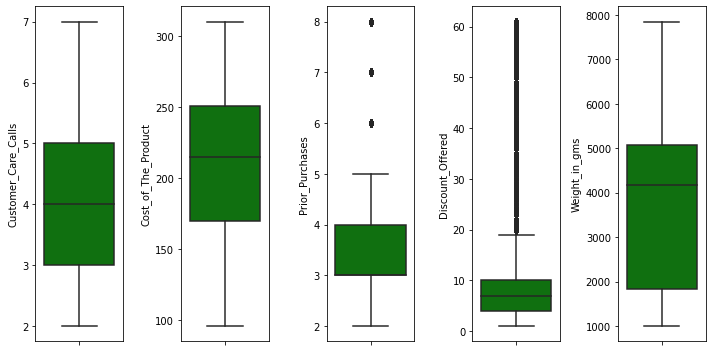

In [ ]:
#boxplot after filter
features = integer
plt.figure(figsize=(10,5))
for i in range(0, len(features)):
  plt.subplot(1, len(features), i+1)
  sns.boxplot(y=df_outlierhandling_z[features[i]], color='green', orient='v')
  plt.tight_layout()

## Split Training and Testing Data

In [ ]:
#define feature(X) and target(Y)
X = df_outlierhandling_z.drop(columns=['ID',
                                       'Warehouse_Block', 'Mode_of_Shipment', 'Product_Importance', 'Gender', 'Customer_Rating(cat)', 'Late_Shipment(cat)',
                                       'norm_Customer_Care_Calls', 'norm_Cost_of_The_Product', 'norm_Prior_Purchases', 'norm_Discount_Offered', 'norm_Weight_in_gms',
                                       'std_Customer_Care_Calls', 'std_Cost_of_The_Product', 'std_Prior_Purchases', 'std_Discount_Offered', 'std_Weight_in_gms',
                                       'log_Discount_Offered', 'log_Prior_Purchases', 'rts_Weight_in_gms', 'Warehouse_Block_F', 'Mode_of_Shipment_Ship', 
                                       'Late_Shipment(num)'])
Y = df_outlierhandling_z['Late_Shipment(num)'] #target/label

#splitting the data into train and test
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression  #import logistic regression from sklearn
logreg = LogisticRegression(random_state=42)         #initialize algorithm with specified name model
logreg.fit(X_train, Y_train)                         #fit algorithm with train data
Y_pred = logreg.predict(X_test)                      #predict Y using testing data

In [ ]:
#confussion matrix
from sklearn.metrics import confusion_matrix #import package from sklearn
confusion_matrix(Y_test, Y_pred)             #see confusion matrix

array([[ 780,  541],
       [ 618, 1254]])

In [ ]:
#call model evaluation function
eval_classification(logreg, X_train, Y_train, X_test, Y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.637
Precision (Test Set): 0.699
Recall (Test Set): 0.670
F1-Score (Test Set): 0.684
AUC (Test Set) : 0.711
Average Precision (Test Set) : 0.824
 
Train Data Evaluation:
Accuracy (Train Set): 0.627
Precision (Train Set): 0.692
Recall (Train Set): 0.666
F1-Score (Train Set): 0.679
AUC (Train Set) : 0.705
Average Precision (Train Set) : 0.824


In [ ]:
#hyperparameter tuning (using random search)

from sklearn.model_selection import RandomizedSearchCV

#tested hyperparameters list
penalty = ['l2','l1', 'elasticnet']
C = [0.0001, 0.001, 0.002] #inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C)

#initiate model
lr = LogisticRegression(random_state=42) #init Logres dengan Gridsearch, cross validation = 5
rs = RandomizedSearchCV(lr, hyperparameters, cv=5, random_state=42, scoring='roc_auc')

#fit model & evaluation
rs.fit(X_train, Y_train)
Y_pred = rs.predict(X_test)

eval_classification(rs, X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Test Data Evaluation:
Accuracy (Test Set): 0.633
Precision (Test Set): 0.691
Recall (Test Set): 0.675
F1-Score (Test Set): 0.683
AUC (Test Set) : 0.713
Average Precision (Test Set) : 0.825
 
Train Data Evaluation:
Accuracy (Train Set): 0.624
Precision (Train Set): 0.687
Recall (Train Set): 0.672
F1-Score (Train Set): 0.679
AUC (Train Set) : 0.705
Average Precision (Train Set) : 0.823


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

In [ ]:
#best hyperparameter? (using random search)
print('Best penalty:', rs.best_estimator_.get_params()['penalty'])
print('Best C:', rs.best_estimator_.get_params()['C'])

Best penalty: l2
Best C: 0.0001


In [ ]:
print('Train score: ' + str(rs.score(X_train, Y_train)))
print('Test score:' + str(rs.score(X_test, Y_test)))

Train score: 0.7047083306285111
Test score:0.7130787508815518


## k-Nearest Neighbor (kNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier  #import knn from sklearn
knn = KNeighborsClassifier()                        #initialize algorithm with specified name model
knn.fit(X_train, Y_train)                           #fit algorithm with train data
Y_pred = knn.predict(X_test)                        #predict Y using testing data 

In [ ]:
#confussion matrix
from sklearn.metrics import confusion_matrix #import package from sklearn
confusion_matrix(Y_test, Y_pred)             #see confusion matrix

array([[ 801,  520],
       [ 608, 1264]])

In [ ]:
#call model evaluation function
eval_classification(knn, X_train, Y_train, X_test, Y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.647
Precision (Test Set): 0.709
Recall (Test Set): 0.675
F1-Score (Test Set): 0.691
AUC (Test Set) : 0.726
Average Precision (Test Set) : 0.806
 
Train Data Evaluation:
Accuracy (Train Set): 0.769
Precision (Train Set): 0.824
Recall (Train Set): 0.776
F1-Score (Train Set): 0.799
AUC (Train Set) : 0.859
Average Precision (Train Set) : 0.888


In [ ]:
#hyperparameter tuning (using random search)

#list of hyperparameter
n_neighbors = list(range(1,51))
p=[1,2,3]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm, weights=weights)

#init model
kn = KNeighborsClassifier()
rs = RandomizedSearchCV(kn, hyperparameters, cv=5, random_state=42, scoring='roc_auc')

#fit model & evaluation
rs.fit(X_train, Y_train)
Y_pred = rs.predict(X_test)
eval_classification(rs, X_train, Y_train, X_test, Y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.659
Precision (Test Set): 0.787
Recall (Test Set): 0.574
F1-Score (Test Set): 0.664
AUC (Test Set) : 0.724
Average Precision (Test Set) : 0.831
 
Train Data Evaluation:
Accuracy (Train Set): 0.691
Precision (Train Set): 0.839
Recall (Train Set): 0.591
F1-Score (Train Set): 0.693
AUC (Train Set) : 0.776
Average Precision (Train Set) : 0.859


In [ ]:
#best hyperparameter? (using random search)
print('Best n_neighbors:', rs.best_estimator_.get_params()['n_neighbors'])
print('Best p:', rs.best_estimator_.get_params()['p'])
print('Best algorithm:', rs.best_estimator_.get_params()['algorithm'])
print('weights:', rs.best_estimator_.get_params()['weights'])

Best n_neighbors: 44
Best p: 2
Best algorithm: kd_tree
weights: uniform


In [ ]:
print('Train score: ' + str(rs.score(X_train, Y_train)))
print('Test score:' + str(rs.score(X_test, Y_test)))

Train score: 0.7763305673261955
Test score:0.7236682906629917


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier       #import decision tree from sklearn
dectree = DecisionTreeClassifier(random_state=42)     #initialize algorithm with specified name model
dectree.fit(X_train, Y_train)                         #fit algorithm with train data
Y_pred = dectree.predict(X_test)                      #predict Y using testing data

In [ ]:
#confussion matrix
from sklearn.metrics import confusion_matrix #import package from sklearn
confusion_matrix(Y_test, Y_pred)             #see confusion matrix

array([[ 735,  586],
       [ 557, 1315]])

In [ ]:
#call model evaluation function
eval_classification(dectree, X_train, Y_train, X_test, Y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.642
Precision (Test Set): 0.692
Recall (Test Set): 0.702
F1-Score (Test Set): 0.697
AUC (Test Set) : 0.629
Average Precision (Test Set) : 0.660
 
Train Data Evaluation:
Accuracy (Train Set): 1.000
Precision (Train Set): 1.000
Recall (Train Set): 1.000
F1-Score (Train Set): 1.000
AUC (Train Set) : 1.000
Average Precision (Train Set) : 1.000


In [ ]:
#hyperparameter tuning (using random search)
from sklearn.model_selection import RandomizedSearchCV

#list of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] #maximum number of levels in tree
min_samples_split = [2, 5, 10, 100, 200] #minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50, 100] #minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt', 'log2'] #number of features to consider at every split
criterion = ['gini', 'entropy'] #the function to measure the quality of a split
splitter = ['best', 'random'] #the strategy used to choose the split at each node

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

#initiate model
dt = DecisionTreeClassifier(random_state=42)
rs = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
rs.fit(X_train, Y_train) #fit model

#predict & evaluation
Y_pred = rs.predict(X_test)
eval_classification(rs, X_train, Y_train, X_test, Y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.630
Precision (Test Set): 0.706
Recall (Test Set): 0.634
F1-Score (Test Set): 0.668
AUC (Test Set) : 0.699
Average Precision (Test Set) : 0.813
 
Train Data Evaluation:
Accuracy (Train Set): 0.674
Precision (Train Set): 0.756
Recall (Train Set): 0.664
F1-Score (Train Set): 0.707
AUC (Train Set) : 0.755
Average Precision (Train Set) : 0.845


In [ ]:
#best hyperparameter? (using random search)
print('Best max_depth:', rs.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', rs.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', rs.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', rs.best_estimator_.get_params()['max_features'])
print('Best criterion:', rs.best_estimator_.get_params()['criterion'])
print('Best splitter:', rs.best_estimator_.get_params()['splitter'])

Best max_depth: 16
Best min_samples_split: 2
Best min_samples_leaf: 100
Best max_features: sqrt
Best criterion: entropy
Best splitter: best


In [ ]:
print('Train score: ' + str(rs.score(X_train, Y_train)))
print('Test score:' + str(rs.score(X_test, Y_test)))

Train score: 0.7545920046202094
Test score:0.6989951522739183


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier    #import random forrest from sklearn
ranfor = RandomForestClassifier(random_state=42)       #initialize algorithm with specified name model
ranfor.fit(X_train, Y_train)                           #fit algorithm with train data

Y_pred = ranfor.predict(X_test)                        #predict Y using testing data 

In [ ]:
eval_classification(ranfor, X_train, Y_train, X_test, Y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.654
Precision (Test Set): 0.741
Recall (Test Set): 0.628
F1-Score (Test Set): 0.680
AUC (Test Set) : 0.725
Average Precision (Test Set) : 0.837
 
Train Data Evaluation:
Accuracy (Train Set): 1.000
Precision (Train Set): 1.000
Recall (Train Set): 1.000
F1-Score (Train Set): 1.000
AUC (Train Set) : 1.000
Average Precision (Train Set) : 1.000


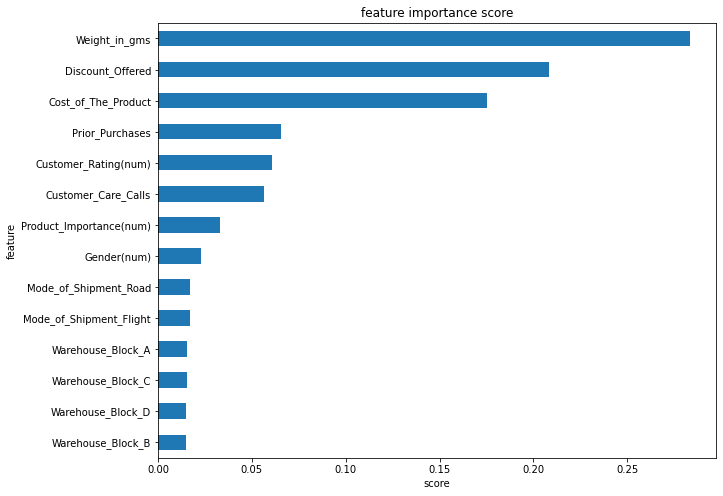

In [ ]:
show_feature_importance(ranfor)

In [ ]:

#List Hyperparameters
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], #total subtree 
                       bootstrap = [True], #use bootstrapping or no
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  #maximum depth of the tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], #total node minimum samples required for new leaf splitting
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], #total leaf minimum samples to form a new leaf
                       max_features = ['auto', 'sqrt', 'log2'], #the number of features to consider when looking for the best split
                       n_jobs = [-1], #the number of jobs to run in parallel computation. -1 means using all processors
                      )

# Init
rf = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
rs.fit(X_train,Y_train)

#predict & evaluation
Y_pred = rs.predict(X_test)
eval_classification(rs, X_train, Y_train, X_test, Y_test)

In [ ]:
#best hyperparameter? (using random search)
print('n_estimators:', rs.best_estimator_.get_params()['n_estimators'])
print('bootstrap:', rs.best_estimator_.get_params()['bootstrap'])
print('criterion:', rs.best_estimator_.get_params()['criterion'])
print('max_depth:', rs.best_estimator_.get_params()['max_depth'])
print('min_samples_split:', rs.best_estimator_.get_params()['min_samples_split'])
print('min_samples_leaf:', rs.best_estimator_.get_params()['min_samples_leaf'])
print('max_features:', rs.best_estimator_.get_params()['max_features'])
print('n_jobs:', rs.best_estimator_.get_params()['n_jobs'])

In [ ]:
show_feature_importance(rs.best_estimator_)

## AdaBoost

In [ ]:
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train,Y_train)

Y_pred = ab.predict(X_test)

In [ ]:
eval_classification(ab, X_train, Y_train, X_test, Y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.663
Precision (Test Set): 0.782
Recall (Test Set): 0.589
F1-Score (Test Set): 0.672
AUC (Test Set) : 0.739
Average Precision (Test Set) : 0.843
 
Train Data Evaluation:
Accuracy (Train Set): 0.680
Precision (Train Set): 0.804
Recall (Train Set): 0.608
F1-Score (Train Set): 0.692
AUC (Train Set) : 0.757
Average Precision (Train Set) : 0.856


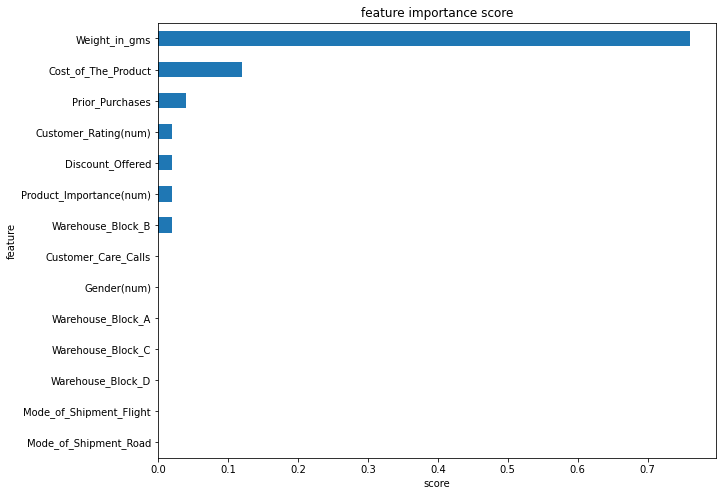

In [ ]:
show_feature_importance(ab)

In [ ]:
# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
adb = AdaBoostClassifier(random_state=42)
rs = RandomizedSearchCV(adb, hyperparameters, random_state=42, cv=5, scoring='roc_auc')
rs.fit(X_train, Y_train)

# Predict & Evaluation
Y_pred = rs.predict(X_test)#Check performa dari model
eval_classification(rs, X_train, Y_train, X_test, Y_test)

In [ ]:
#best hyperparameter? (using random search)
print('n_estimators:', rs.best_estimator_.get_params()['n_estimators'])
print('learning_rate:', rs.best_estimator_.get_params()['learning_rate'])
print('algorithm:', rs.best_estimator_.get_params()['algorithm'])

n_estimators: 1700
learning_rate: 0.011421052631578946
algorithm: SAMME.R


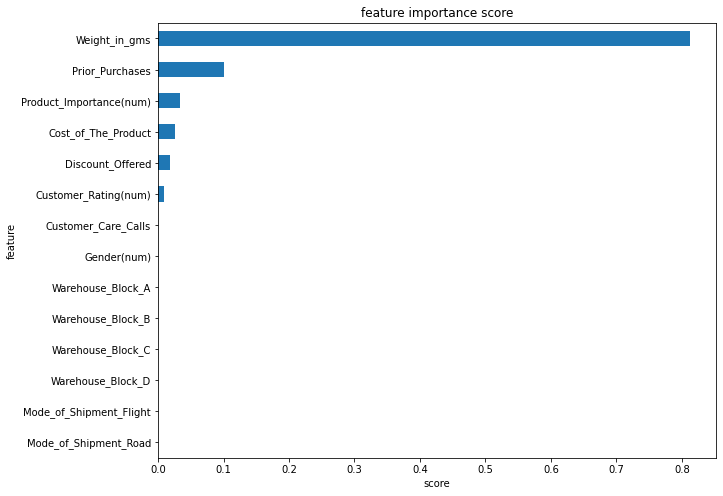

In [ ]:
show_feature_importance(rs.best_estimator_)

## XGBoost

In [ ]:
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg.fit(X_train, Y_train)

Y_pred = xg.predict(X_test)

In [ ]:
eval_classification(xg, X_train, Y_train, X_test, Y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.669
Precision (Test Set): 0.847
Recall (Test Set): 0.530
F1-Score (Test Set): 0.652
AUC (Test Set) : 0.732
Average Precision (Test Set) : 0.842
 
Train Data Evaluation:
Accuracy (Train Set): 0.706
Precision (Train Set): 0.910
Recall (Train Set): 0.559
F1-Score (Train Set): 0.693
AUC (Train Set) : 0.797
Average Precision (Train Set) : 0.880


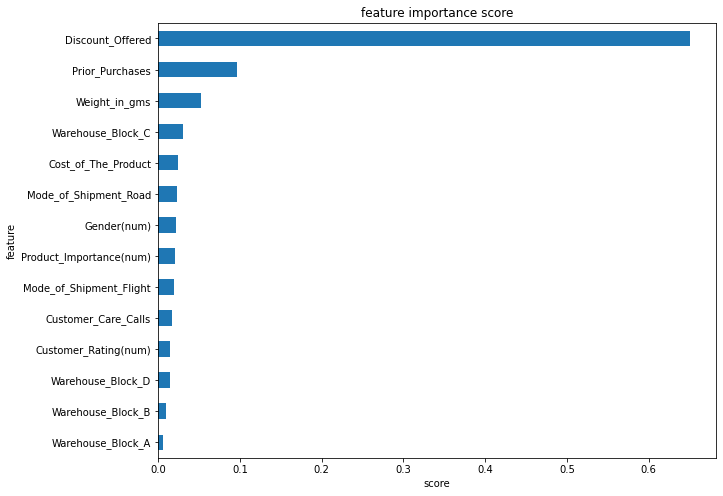

In [ ]:
show_feature_importance(xg)

In [ ]:
#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
xgb = XGBClassifier(random_state=42)
rs = RandomizedSearchCV(xgb, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
rs.fit(X_train, Y_train)

# Predict & Evaluation
Y_pred = rs.predict(X_test)#Check performa dari model
eval_classification(rs, X_train, Y_train, X_test, Y_test)

Test Data Evaluation:
Accuracy (Test Set): 0.665
Precision (Test Set): 0.761
Recall (Test Set): 0.624
F1-Score (Test Set): 0.686
AUC (Test Set) : 0.732
Average Precision (Test Set) : 0.844
 
Train Data Evaluation:
Accuracy (Train Set): 0.780
Precision (Train Set): 0.879
Recall (Train Set): 0.728
F1-Score (Train Set): 0.796
AUC (Train Set) : 0.880
Average Precision (Train Set) : 0.924


In [ ]:
#best hyperparameter? (using random search)
print('max_depth:', rs.best_estimator_.get_params()['max_depth'])
print('min_child_weight:', rs.best_estimator_.get_params()['min_child_weight'])
print('gamma:', rs.best_estimator_.get_params()['gamma'])
print('tree_method:', rs.best_estimator_.get_params()['tree_method'])
print('colsample_bytree:', rs.best_estimator_.get_params()['colsample_bytree'])
print('eta:', rs.best_estimator_.get_params()['eta'])
print('lambda:', rs.best_estimator_.get_params()['lambda'])
print('alpha:', rs.best_estimator_.get_params()['alpha'])

max_depth: 50
min_child_weight: 18
gamma: 0.5
tree_method: approx
colsample_bytree: 0.30000000000000004
eta: 0.33333333333333337
lambda: 0.8
alpha: 0.8


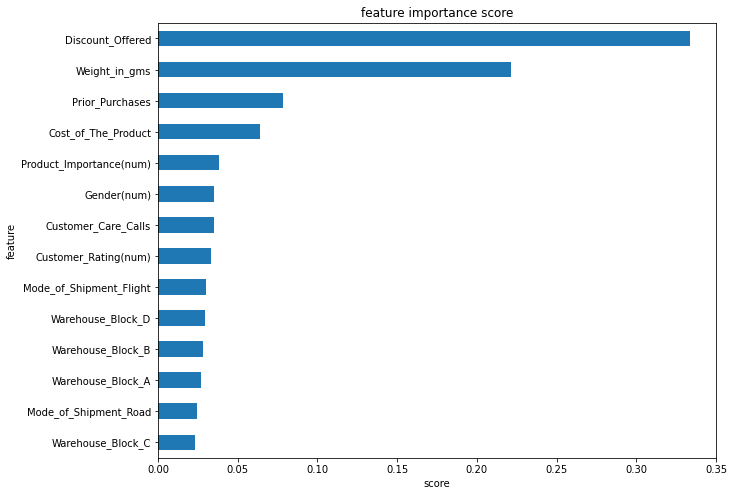

In [ ]:
show_feature_importance(rs.best_estimator_)

# Iterasi Feature Importance dengan Adaboost

## Model 1

In [ ]:
# Splitting Features & Target
X1 = dfori[['Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']] # Features
Y1 = dfori['Reached.on.Time_Y.N'] # Target

#splitting the data into train and test
from sklearn.model_selection import train_test_split 
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size = 0.3, random_state = 42)

In [ ]:
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train1, Y_train1)

Y_pred = ab.predict(X_test1)
eval_classification(ab, X_train1, Y_train1, X_test1, Y_test1)

Test Data Evaluation:
Accuracy (Test Set): 0.644
Precision (Test Set): 0.695
Recall (Test Set): 0.728
F1-Score (Test Set): 0.711
AUC (Test Set) : 0.739
Average Precision (Test Set) : 0.850
 
Train Data Evaluation:
Accuracy (Train Set): 0.650
Precision (Train Set): 0.693
Recall (Train Set): 0.737
F1-Score (Train Set): 0.715
AUC (Train Set) : 0.751
Average Precision (Train Set) : 0.852


In [ ]:
# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
adb = AdaBoostClassifier(random_state=42)
rs = RandomizedSearchCV(adb, hyperparameters, random_state=42, cv=5, scoring='roc_auc')
rs.fit(X_train1, Y_train1)

# Predict & Evaluation
Y_pred = rs.predict(X_test1)#Check performa dari model
eval_classification(rs, X_train1, Y_train1, X_test1, Y_test1)

Test Data Evaluation:
Accuracy (Test Set): 0.679
Precision (Test Set): 0.806
Recall (Test Set): 0.615
F1-Score (Test Set): 0.698
AUC (Test Set) : 0.743
Average Precision (Test Set) : 0.847
 
Train Data Evaluation:
Accuracy (Train Set): 0.678
Precision (Train Set): 0.797
Recall (Train Set): 0.615
F1-Score (Train Set): 0.694
AUC (Train Set) : 0.752
Average Precision (Train Set) : 0.847


## Model 2

In [ ]:
# Split Feature and Label
X2 = df_log[['Cost_of_the_Product', 'Weight_in_gms', 'log_Discount_Offered', 'log_Prior_Purchases' ]]
Y2 = df_log['Reached.on.Time_Y.N'] # target / label

#splitting the data into train and test
from sklearn.model_selection import train_test_split 
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size = 0.3, random_state = 42)

In [ ]:
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train2, Y_train2)

Y_pred = ab.predict(X_test2)
eval_classification(ab, X_train2, Y_train2, X_test2, Y_test2)

Accuracy (Test Set): 0.68
Precision (Test Set): 0.85
Recall (Test Set): 0.58
F1-Score (Test Set): 0.69
AUC: 0.75


In [ ]:
# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
adb = AdaBoostClassifier(random_state=42)
rs = RandomizedSearchCV(adb, hyperparameters, random_state=42, cv=5, scoring='roc_auc')
rs.fit(X_train2, Y_train2)

# Predict & Evaluation
Y_pred = rs.predict(X_test2)#Check performa dari model
eval_classification(rs, X_train2, Y_train2, X_test2, Y_test2)

Test Data Evaluation:
Accuracy (Test Set): 0.679
Precision (Test Set): 0.806
Recall (Test Set): 0.615
F1-Score (Test Set): 0.698
AUC (Test Set) : 0.743
Average Precision (Test Set) : 0.847
 
Train Data Evaluation:
Accuracy (Train Set): 0.678
Precision (Train Set): 0.797
Recall (Train Set): 0.615
F1-Score (Train Set): 0.694
AUC (Train Set) : 0.752
Average Precision (Train Set) : 0.847


## Model 3

In [ ]:
# train test split
X3 = df_shipping[['Cost_of_the_Product', 'Weight_in_gms', 'Discount_offered', 'Prior_purchases' ]]
Y3 = df_shipping['Reached.on.Time_Y.N']
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X2, Y2, test_size=0.3, random_state=42)
print("training: ", X_train2.shape[0])
print("testing: ", Y_test2.shape[0])

training:  7699
testing:  3300


In [ ]:
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train3, Y_train3)

Y_pred = ab.predict(X_test3)
eval_classification(ab, X_train3, Y_train3, X_test3, Y_test3)

Test Data Evaluation:
Accuracy (Test Set): 0.683
Precision (Test Set): 0.848
Recall (Test Set): 0.577
F1-Score (Test Set): 0.687
AUC (Test Set) : 0.746
Average Precision (Test Set) : 0.856
 
Train Data Evaluation:
Accuracy (Train Set): 0.689
Precision (Train Set): 0.854
Recall (Train Set): 0.576
F1-Score (Train Set): 0.688
AUC (Train Set) : 0.761
Average Precision (Train Set) : 0.860


In [ ]:
# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
adb = AdaBoostClassifier(random_state=42)
rs = RandomizedSearchCV(adb, hyperparameters, random_state=42, cv=5, scoring='roc_auc')
rs.fit(X_train3, Y_train3)

# Predict & Evaluation
Y_pred = rs.predict(X_test3)#Check performa dari model
eval_classification(rs, X_train3, Y_train3, X_test3, Y_test3)

## Model 4

In [ ]:
#define feature(X) and target(Y)
X4 = df_outlierhandling_z[['Cost_of_The_Product', 'Prior_Purchases', 'Discount_Offered', 'Weight_in_gms']]
Y4 = df_outlierhandling_z['Late_Shipment(num)'] #target/label

#splitting the data into train and test
from sklearn.model_selection import train_test_split 
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, Y4, test_size = 0.3, random_state = 42)

In [ ]:
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train4, Y_train4)

Y_pred = ab.predict(X_test4)

In [ ]:
eval_classification(ab, X_train4, Y_train4, X_test4, Y_test4)

Test Data Evaluation:
Accuracy (Test Set): 0.669
Precision (Test Set): 0.807
Recall (Test Set): 0.573
F1-Score (Test Set): 0.670
AUC (Test Set) : 0.735
Average Precision (Test Set) : 0.840
 
Train Data Evaluation:
Accuracy (Train Set): 0.681
Precision (Train Set): 0.832
Recall (Train Set): 0.578
F1-Score (Train Set): 0.682
AUC (Train Set) : 0.753
Average Precision (Train Set) : 0.852


In [ ]:
# List of hyperparameter
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 20)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
adb = AdaBoostClassifier(random_state=42)
rs = RandomizedSearchCV(adb, hyperparameters, random_state=42, cv=5, scoring='roc_auc')
rs.fit(X_train4, Y_train4)

# Predict & Evaluation
Y_pred = rs.predict(X_test4)#Check performa dari model
eval_classification(rs, X_train4, Y_train4, X_test4, Y_test4)

Test Data Evaluation:
Accuracy (Test Set): 0.671
Precision (Test Set): 0.774
Recall (Test Set): 0.619
F1-Score (Test Set): 0.688
AUC (Test Set) : 0.741
Average Precision (Test Set) : 0.831
 
Train Data Evaluation:
Accuracy (Train Set): 0.670
Precision (Train Set): 0.776
Recall (Train Set): 0.622
F1-Score (Train Set): 0.690
AUC (Train Set) : 0.743
Average Precision (Train Set) : 0.835
